In [1]:
# Initialization
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hddm
import numpy as np
import pickle
from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.analyze import post_pred_gen
from kabuki.utils import concat_models
import pathlib

In [2]:
print (hddm.__version__)

1.0.1RC


In [3]:
data_F = hddm.load_csv('./HDDM_InconStim_6Frame.csv')

In [4]:
data_F.head(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
0,114192,2,0.984893,6,e,1,BlockFvN,1,A,2,1,2
1,114192,6,0.926056,6,e,1,BlockFvN,1,B,1,2,2
2,114192,9,0.854008,6,e,1,BlockFvN,1,B,1,2,2
3,114192,11,0.881858,6,e,1,BlockFvN,1,B,1,2,2
4,114192,12,0.918875,6,e,1,BlockFvN,1,B,1,2,2
5,114192,13,0.906791,6,e,1,BlockFvN,1,B,1,2,2
6,114192,15,0.949124,6,f,0,BlockFvN,1,A,2,1,2
7,114192,16,0.839553,6,e,1,BlockFvN,1,A,2,1,2
8,114192,17,1.006603,6,f,0,BlockFvN,1,A,2,1,2
9,114192,24,0.855258,6,f,0,BlockFvN,1,A,2,1,2


In [5]:
data_F.tail(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
9740,993849,330,0.601870,6,n,0,BlockF_1,2,B,1,2,2
9741,993849,331,0.681040,6,b,1,BlockF_1,2,A,2,1,2
9742,993849,332,0.599069,6,b,1,BlockF_1,2,B,1,2,2
9743,993849,334,0.551520,6,n,0,BlockF_1,2,A,2,1,2
9744,993849,336,0.538108,6,b,1,BlockF_1,2,B,1,2,2
9745,993849,339,0.776732,6,b,1,BlockF_1,2,A,2,1,2
9746,993849,341,0.503375,6,n,0,BlockF_1,2,A,2,1,2
9747,993849,343,0.515187,6,n,0,BlockF_1,2,B,1,2,2
9748,993849,344,0.614084,6,b,1,BlockF_1,2,A,2,1,2
9749,993849,349,0.615294,6,b,1,BlockF_1,2,B,1,2,2


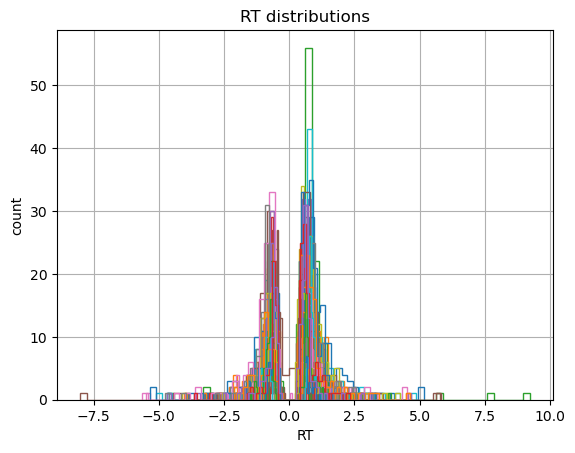

In [6]:
# Plot the RT distributions for the upper (+) and lower (-) bounds
# first flip the RT for the lower bound using flip error, i.e., the lower bound RT to make it negative
data_F = hddm.utils.flip_errors(data_F)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel = 'RT', ylabel = 'count', title = 'RT distributions')
for i, subj_data in data_F.groupby('subj_idx'):
    subj_data.rt.hist(bins = 50, histtype = 'step', ax = ax)
    
plt.savefig('./testrt.pdf')


In [7]:
# base model where all parameteres are estimated at subject level
# instantiate model object (no need to call flip_errors() before passing it).

# configure dependencies
dependancies = {'v':['HSF_emo']}

# tailoring an individual hierarchical DDM around dataset.
m1 = hddm.HDDM(data_F, include=('z', 'v', 'a', 't'),depends_on = dependancies, p_outlier = 0.05, informative = False)

# find good starting point. helps with convergence
m1.find_starting_values()
# start drawing 5000 samples and discarding 25000 as burn-in, every 2th thinned
m1.sample(5000, burn=2500, thin = 2, dbname = './m1_traces.db', db = 'pickle')

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 1209.9 sechddm sampling elpased time:  1210.151 s


In [8]:
m1.save('./m1_traces')

In [9]:
stats = m1.gen_stats()
m1.print_stats()

                      mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                 1.349448  0.028695  1.291317  1.330291  1.349895  1.368976  1.403328  0.000842
a_std             0.228994  0.023178  0.186111  0.212817  0.228236  0.243144  0.278608   0.00083
a_subj.114192     1.401702  0.070123  1.261536  1.353666  1.398732  1.450112   1.54588  0.002491
a_subj.136867     1.341034  0.053958  1.242512  1.304227  1.339863  1.375788   1.45235  0.001984
a_subj.152317     1.290386  0.053866  1.189986  1.253267  1.288266  1.324835  1.402975  0.001662
a_subj.160211     1.165637  0.052999  1.070277  1.128828  1.162592    1.2007  1.274038  0.001598
a_subj.185005     1.306368  0.063309   1.19001  1.263623  1.304682  1.344545   1.43849  0.002128
a_subj.207436     1.546934  0.072453  1.411112  1.500019  1.546222  1.591789  1.698466  0.002638
a_subj.215147     1.362353  0.060994  1.246043  1.321197  1.359933  1.400629  1.495196  0.002045
a_subj.243315     1.342758  0.

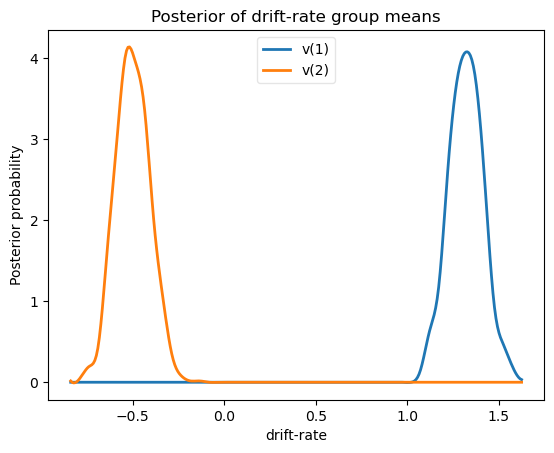

In [10]:
v_1, v_2 = m1.nodes_db.node[['v(1)','v(2)']]
hddm.analyze.plot_posterior_nodes([v_1,v_2])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('./m1dr.pdf', bbox_inches ="tight")

In [11]:
stats.to_csv('data.csv')